# Prioritized Scenarios - Third Run

Author: Katherine Shaw
Date: Aug 28, 2025

This file differs from second run analysis because it includes hydrogen turbine as an option in the configuration file and it changes the heating function to be divided among the countries. Otherwise the Analysis is the same as the second run scenarios.

In [1]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

In [ ]:
#Analysis Functions 
#functions to make tests: 
def hydrogen_electrolysis_limit_test(network, year):
    BAU_hydrogen_limits = {2020: 250, 2030: 40000, 2040: 425000, 2050: 550000} #this is in MW, the original dictionary in the configuration file is in MW

    print('Does a hydrogen limit exist?')
    if 'capacity_maximum-expansion-Europe-Link-H2-Electrolysis' in network.global_constraints.index:
        print('Yes')
        print('')

    print('does the hydrogen limit plus the installed capacity equal the limit in the configuration file?')
    installed_electrolysis_capacity = network.statistics()['Installed Capacity'].loc[('Link', 'H2 Electrolysis')]
    global_constraint_expansion_capacity = network.global_constraints['constant'].loc['capacity_maximum-expansion-Europe-Link-H2-Electrolysis']
    total = installed_electrolysis_capacity + global_constraint_expansion_capacity 
    if total - BAU_hydrogen_limits[year] < 2:
        print('Yes, constraint working and abided by')
        print('')

def carbon_sequestration_limit_test(network, year):
    BAU_Carbon_sequestration_limits = {2020: 0, 2030: 50, 2040: 280, 2050: 450}

    print('Does the Carbon sequestration limit exist?')
    if 'co2_sequestration_limit' in network.global_constraints.index:
        print('Yes')
    
    print('does the carbon sequestration amount is equal to the BAU appropriate configuration value')
    carbon_sequestration_limit = network.global_constraints['constant'].loc['co2_sequestration_limit']
    if carbon_sequestration_limit - BAU_Carbon_sequestration_limits[year] <= 1:
        print('Yes')
        print('')

def transmission_limit_test(network, year):
    transmission_limit = ('transmission_expansion_cost_limit' in network.global_constraints.type.unique())
    if transmission_limit:
        print('Yes, transmission limit exists')
    else:
        print('No transmission limit')
    
def carbon_constraint_check(network):
    carbon_constraint = network.global_constraints.loc['CO2Limit'].constant
    carbon_stores = network.stores_t.e['co2 atmosphere']['2019-12-31 18:00:00']
    
    if 'CO2Limit' in network.global_constraints.index:
        print('Carbon constraint exists')
    
    if (carbon_constraint - carbon_stores < 1):
        print('Yes, Carbon constraint abided by ')
    else:
        print('WARNING: Carbon constraint violated')

#curtailment options
def curtailment_dataframe_calculation(network):
#ok so this from make summaries isn't bad, but I want total mw hours and percentages, I understand if it's in percentages it doesn't matter because they cancel out but I want something new
        avail = (network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
                .mul(network.snapshot_weightings.objective[0])#now it's in MWh -- power average over 6 hours times number of hours
                .sum() #sum of each potential dispatch at p_max_pu with p_nom_opt
                .groupby(network.generators.carrier)
                .sum()
        ) 
        avail
        used = (network.generators_t.p
                .mul(network.snapshot_weightings.objective[0]) #multiplying the average dispatch in MW over the 6 hour period by the time period, 6 hr 
                .sum()
                .groupby(network.generators.carrier)
                .sum()
        )
        curtailed_in_megawatthours = avail - used
        curtailed_in_megawatthours = curtailed_in_megawatthours[curtailed_in_megawatthours > 0]
        curtailed_in_megawatthours

        #relative to what would have been available from the wind or solar resource, so franction is related to available power as well? 
        curtailment_fraction = (avail - used) / avail * 100 #now it's in percentages
        curtailment_fraction = curtailment_fraction[curtailment_fraction >0] #to remove negative infinities form conventional generators
        curtailment_fraction = curtailment_fraction[curtailment_fraction < 110] # to remove positive infinity from heat vent
        curtailment_fraction

        curtailment_dataframe = pd.DataFrame()
        curtailment_dataframe['Curtailment in MWh'] = curtailed_in_megawatthours
        curtailment_dataframe['Curtailment Fraction (with respect to available power)'] = curtailment_fraction
        return curtailment_dataframe

def combine_with_suffixes(dfs, suffixes):
    """
    Combine multiple DataFrames with the same index,
    renaming their columns with the provided suffixes.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of DataFrames to combine.
    suffixes : list of str
        List of suffix strings to apply to each DataFrame's columns.

    Returns
    -------
    combined : pd.DataFrame
        DataFrame with suffixed columns aligned by index.
    """
    if len(dfs) != len(suffixes):
        raise ValueError("Length of dfs and suffixes must match")

    renamed = [df.add_suffix(suf) for df, suf in zip(dfs, suffixes)]
    combined = pd.concat(renamed, axis=1)
    combined
    return combined

#These functions create the bar chart with information about the renewable nature of the TWH produced in the whole sytem
def stacked_side_bar(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)].index 
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass']

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[(network.generators[network.generators.carrier.isin(low_carbon_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.generators_t.p[(network.generators[network.generators.carrier.isin(traditional_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
 
    #hydro
    hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
    hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [(renewable_production.sum() + hydro_dispatch.sum()), low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    right_edge_x = total  # <-- NEW: define rightmost edge of the bar

    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x, segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = f"{(val / total) * 100:.2f}"  # <-- FIXED: works for floats

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha='center', va='bottom', fontsize=9, color='k')

        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    return fig

def stacked_side_bar_electric(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
   #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'ror'] #no solar thermal, though an argument could perhaps be made
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

    #all buses that are acceptable 
    electric_buses = network.buses[network.buses.unit == 'MWh_el'].index #AC, battery, EV battery, low voltage, home battery 
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)]
    renewable_generators = renewable_generators[renewable_generators.bus.isin(electric_buses)]
    renewable_generators = renewable_generators.index

    low_carbon_generators = network.generators[network.generators.carrier.isin(low_carbon_carriers)]
    low_carbon_generators = low_carbon_generators[low_carbon_generators.bus.isin(electric_buses)]
    low_carbon_generators = low_carbon_generators.index

    #conventional generators harder to nab, if I want to get to what was contributed to the power sector, have to take a different approach 
    conventional_generators = network.generators[network.generators.carrier.isin(traditional_carriers)]
    #conventional_generators = conventional_generators[conventional_generators.bus.isin(electric_buses)]
    #conventional_generators = conventional_generators.index 
    conventional_generators

    network.links.carrier.unique()
    #need all the links that come from a conventional bus and go into a electric bus
    thermal_to_power = network.links[network.links.bus1.isin(electric_buses)][~network.links.bus0.isin(electric_buses)]
    thermal_to_power = thermal_to_power[~(thermal_to_power.carrier == 'nuclear')]#get rid of all nuclear, because that is one I already have in low carbon power
    thermal_to_power = thermal_to_power.index 

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[low_carbon_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.links_t.p1[thermal_to_power] * network.snapshot_weightings.objective[0]).T.groupby(network.links.carrier).sum().T.sum() #MWh
    conventional_production = conventional_production * -1 #because it's power delivered to the electric bus 

    #hydro
    hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
    hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [(renewable_production.sum() + hydro_dispatch.sum()) , low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    right_edge_x = total  # <-- NEW: define rightmost edge of the bar
    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x,segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = str(((val/total) * 100).round(2))

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha = 'center', va = 'bottom', fontsize = 9, color = 'k')


        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    #return fig
    
#this function aids the demand function seperate the different types of demand (by carrier)
def load_dataframe_compiler(network, sector_suffix): #this still returns load dataframes in terms of power dispatch, not in total energy (so MW, not MWH)
    import pandas as pd
    import numpy as np

    # Create a dummy dataframe with load dispatch
    df = pd.DataFrame(network.loads_t.p.T.copy())

    # All loads and their static information 
    df_loads = network.loads.copy()
    carrier_options = df_loads.carrier.unique()

    # Prepare suffix list and remap 'electricity' to empty string
    suffixes = carrier_options.copy()
    if 'electricity' in suffixes:
        suffixes[np.where(suffixes == 'electricity')[0][0]] = ''

    # Check that the given sector_suffix is valid
    if sector_suffix not in suffixes:
        print('network suffix not in suffix list')
        return None

    # Filtering logic
    if sector_suffix == '':
        # Keep only rows where the index suffix after first 5 chars is exactly ''
        filtered_df = df[df.index.str[5:] == ''].copy()
    else:
        # Match any index containing the suffix
        filtered_df = df[df.index.str.contains(sector_suffix, regex=False)].copy()

    return filtered_df

def Electric_demand_plot(network):
    fig, ax = plt.subplots(figsize = (14,6))
    electric_loads_in_time = load_dataframe_compiler(network_choice, '').sum().div(1e3) #turning into GW
    transport_loads_in_power_sector = load_dataframe_compiler(network_choice, 'land transport EV').sum().div(1e3) #turning into GW
    #plt.ylabel('GW')
    #electric heating dispatch
    heating_buses = network_choice.buses[network_choice.buses.carrier.isin(['urban central heat', 'urban decentral heat', 'rural heat'])]
    electric_buses = network_choice.buses[network_choice.buses.unit == 'MWh_el']
    heating_to_electric_links = network_choice.links[network_choice.links.bus1.isin(heating_buses.index)][network_choice.links.bus0.isin(electric_buses.index)]
    #heating_to_electric_links.carrier.unique() #carriers include heat pumps and resistive heaters, good. 
    heating_to_electric_link_pull_from_power_sector = network_choice.links_t.p0[heating_to_electric_links.index]
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.T.sum()
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.div(1e3)

    type_dispatch_dataframe = pd.DataFrame()
    type_dispatch_dataframe['Electric Transport Load [GW]'] = transport_loads_in_power_sector
    type_dispatch_dataframe['Electric Heating Load [GW]'] = heating_to_electric_link_pull_from_power_sector
    type_dispatch_dataframe['Electric Loads [GW]'] = electric_loads_in_time
    type_dispatch_dataframe.plot(
            ax = ax,
            kind = 'area',
            stacked = True,
            cmap = 'tab20'
        )
    return fig


def network_list_summary(network_list):
    #overall cost of system
    print('network objective')
    print(
        f'2020 : {network_list[0].objective:.2e} \n'
        f'2030 : {network_list[1].objective:.2e} \n' 
        f'2040 : {network_list[2].objective:.2e} \n' 
        f'2050 : {network_list[3].objective:.2e} \n'
    )
    #system makeup - total 
    print('system makeup -- all sectors')
    print('2020')
    stacked_side_bar(network_list[0])
    print('2030')
    stacked_side_bar(network_list[1])
    print('2040')
    stacked_side_bar(network_list[2])
    print('2050')
    stacked_side_bar(network_list[3])
    #system makep - power sector 
    print('system makeup -- power sector')
    print('2020')
    stacked_side_bar_electric(network_list[0])
    print('2030')
    stacked_side_bar_electric(network_list[1])
    print('2040')
    stacked_side_bar_electric(network_list[2])
    print('2050')
    stacked_side_bar_electric(network_list[3])

    #hydrogen buildout 
    #carbon sequestered and overal carbon 
    [carbon_constraint_check(n) for n in BAU_no_flex_network_list]



# BAU - No Flex and Max Flex

In [3]:
BAU_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_no_flex/networks/base_s_39___2020.nc')
BAU_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_no_flex/networks/base_s_39___2030.nc')
BAU_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_no_flex/networks/base_s_39___2040.nc')
BAU_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_no_flex/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
BAU_no_flex_network_list = [BAU_no_flex_2020, BAU_no_flex_2030, BAU_no_flex_2040, BAU_no_flex_2050 ]

#### Validation

In [443]:
#BAU validation against ENTSO-E  -- functions to do the comparison
historic_entsoe_2020 = pd.read_csv(
    '/Users/katherine.shaw/Desktop/pypsa-eur/2020 entsoe-e/historical_electricity_production.csv',
    index_col=0,
    header=[0, 1],
    parse_dates=True,
)

subset_technologies = ["Geothermal", "Nuclear", "Biomass", "Lignite", "Oil", "Coal"]
lowercase_technologies = [
    technology.lower() if technology in subset_technologies else technology
    for technology in historic_entsoe_2020.columns.levels[1]
    ]
historic_entsoe_2020.columns = historic_entsoe_2020.columns.set_levels(lowercase_technologies, level=1)



def combine_series_by_dictionary(series1: pd.Series, series2: pd.Series, matched_data_dictionary: dict) -> pd.DataFrame:
    """
    Combines two pandas Series into a single DataFrame based on a dictionary
    that maps multiple source indices to a single target index.
    Values for matched source indices are summed under the target index.
    Rows in the series that do not match any dictionary values are ignored.

    Args:
        series1 (pd.Series): The first pandas Series.
        series2 (pd.Series): The second pandas Series.
        matched_data_dictionary (dict): A dictionary where keys are the
                                        desired new DataFrame indices, and
                                        values are lists of original indices
                                        to be mapped to that new index.

    Returns:
        pd.DataFrame: A DataFrame with the aggregated values under the new indices.
    """
    
    # Initialize a dictionary to store the aggregated data
    combined_data = {}

    # Iterate through the target indices and their corresponding source indices
    for target_index, source_indices_list in matched_data_dictionary.items():
        total_value_series1 = 0
        total_value_series2 = 0
        
        # Aggregate values for series1
        for source_index in source_indices_list:
            if source_index in series1.index:
                total_value_series1 += series1.loc[source_index]
        
        # Aggregate values for series2
        for source_index in source_indices_list:
            if source_index in series2.index:
                total_value_series2 += series2.loc[source_index]
        
        # Store the aggregated values for this target_index
        combined_data[target_index] = {
            'Series1_Value': total_value_series1,
            'Series2_Value': total_value_series2
        }
    
    # Create a DataFrame from the combined data
    # Orienting from_dict to 'index' makes the dictionary keys the DataFrame index
    df = pd.DataFrame.from_dict(combined_data, orient='index')
    
    # Ensure columns are properly named
    df.columns = ['Historic', 'Optimized']
    
    return df

matched_data_dictionary2 = {
    'Onshore Wind': ['Onshore Wind', 'onwind', 'onshore wind'],
    'Offshore Wind': ['Offshore Wind', 'Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'offwind-ac', 'offwind-dc', 'offwind-float', 'offshore wind'],
    'Solar' : ['Solar', 'solar-hsat', 'solar', 'solar rooftop'],
    'Nuclear': ['Nuclear', 'nuclear'], 
    'Run of River': ['Run of River', 'ror'],
    'Hydro': ['Hydro', 'hydro', 'PHS', 'Pumped Hydro Storage', 'Reservoir & Dam'],
    'Coal': ['Coal', 'coal'], 
    'Lignite': ['Lignite', 'lignite'],
    'Gas': ['Gas', 'gas', 'Combined-Cycle Gas', 'Open-Cycle Gas', 'CCGT', 'OCGT',  "urban central CHP", "urban central CHP CC"],
    'Geothermal': ['Geothermal', 'geothermal'],
    'Biomass': ['Biomass', 'solid biomass', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC', 'biomass'],
    'Other': ['Other'],
    'Oil': ['oil', 'Oil']
    }
#To graph the result:
'''
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="y")
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()
''' 

def electric_supply_from_the_sector_models(network_choice):
    #gets the total supply from the various carriers to the electric sector of the model, where applicable 
    ##the renewable generators connect directly to the AC buses 
    ## the conventional links deliver a certain amount of energy to the AC buses -- in the sector models the big loads are connected to the low voltage buses
  network = network_choice
  supply = {}

    #renewables 
  renewable_carriers = ['solar', 'offwind-dc', 'onwind',
       'offwind-ac', 'offwind-float', 'solar-hsat', 'ror', 'solar rooftop', 'hydro', 'ror', 'PHS']
      #generators 
  renewable_generators_by_carrier = network.generators[network.generators.carrier.isin(renewable_carriers)].index
  renewable_generators_by_carrier 
  renewables_dispatch = network.generators_t.p[renewable_generators_by_carrier]
  renewables_dispatch = renewables_dispatch.T
  renewables_dispatch=renewables_dispatch.groupby(network.generators.carrier).sum()
  renewables_dispatch = renewables_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh 
  renewables_dispatch = renewables_dispatch.sum(axis=1)
    #low carbon carriers
  low_carbon_carriers = ['nuclear', 'geothermal']
  low_carbon_carriers = network.generators[network.generators.carrier.isin(low_carbon_carriers)].index
  low_carbon_dispatch = network.generators_t.p[low_carbon_carriers]
  low_carbon_dispatch = low_carbon_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh
  low_carbon_dispatch = low_carbon_dispatch.T
  low_carbon_dispatch = low_carbon_dispatch.groupby(network.generators.carrier).sum()
  low_carbon_dispatch = low_carbon_dispatch.sum(axis=1)
  low_carbon_dispatch
    #conventional carriers = 
  conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC", 'H2 turbine', 'H2 Fuel Cell'] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central
  conventional_links = network.links[network.links.carrier.isin(conventional_carriers)].index
  conventional_links = network.links_t.p1[conventional_links]#power delivered to the end bus 
  conventional_links = conventional_links * network.snapshot_weightings.objective[0] * -1 #MW --> MWh, and multiplied by netgative one because contributing power to those buses
  conventional_links = conventional_links.T
  conventional_links = conventional_links.groupby(network.links.carrier).sum()
  conventional_links = conventional_links.sum(axis=1)
  conventional_links
  
  #hydro
  hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
  hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh



  dispatch_dict = {k: v for s in [renewables_dispatch, low_carbon_dispatch, conventional_links, hydro_dispatch] for k, v in s.items()}
  return dispatch_dict 



All (including Sector) Components compared to Entsoe E

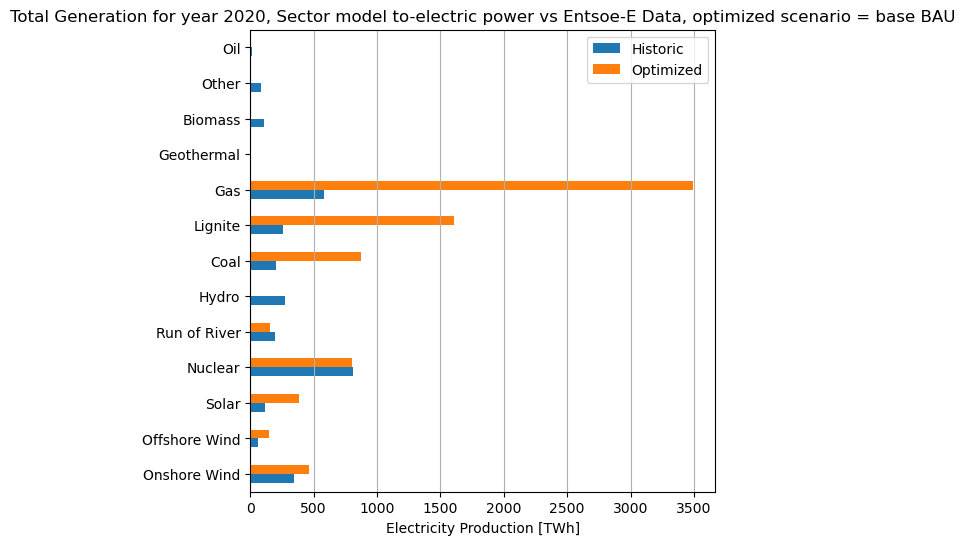

In [6]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), BAU_no_flex_2020.statistics().loc['Generator']['Supply'], matched_data_dictionary2)
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

Electric Components compared to Entsoe E

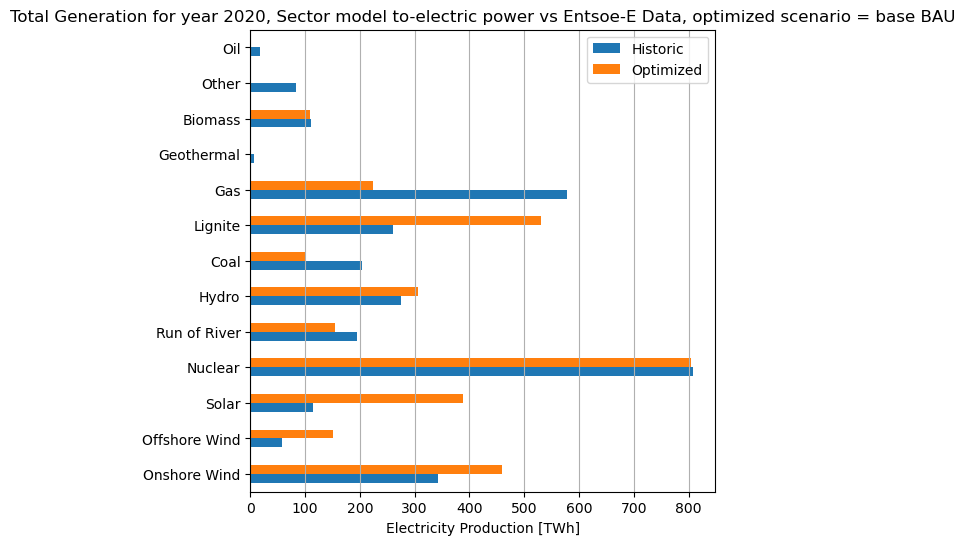

In [7]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(BAU_no_flex_2020)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

In [8]:
for i, network in enumerate(BAU_no_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])
    


Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, const

#### Network Metrics - BAU

network objective
2020 : 5.37e+11 
2030 : 4.59e+11 
2040 : 5.29e+11 
2050 : 1.27e+11 

system makeup -- all sectors
2020


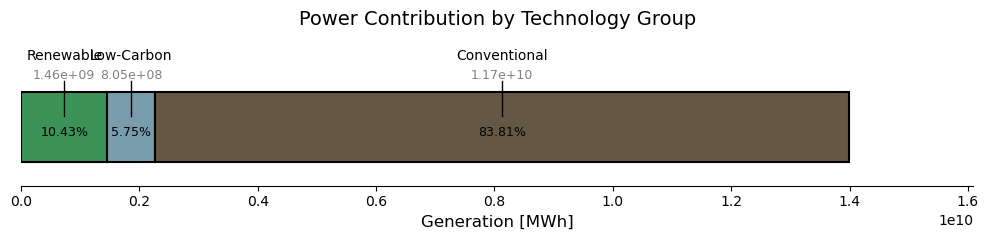

2030


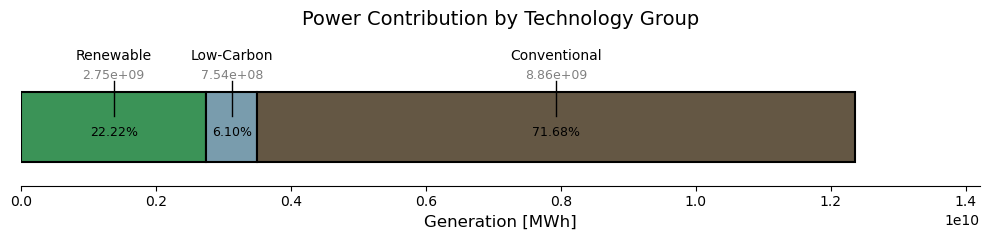

2040


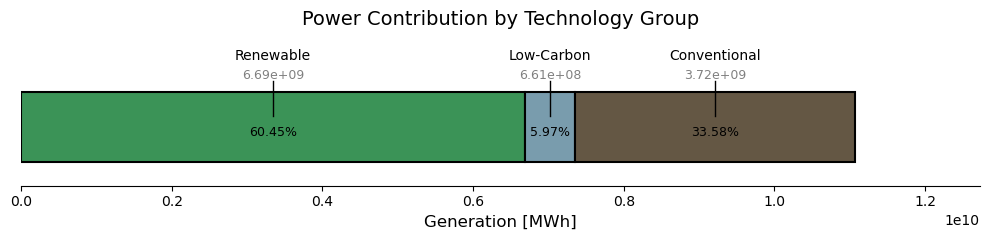

2050


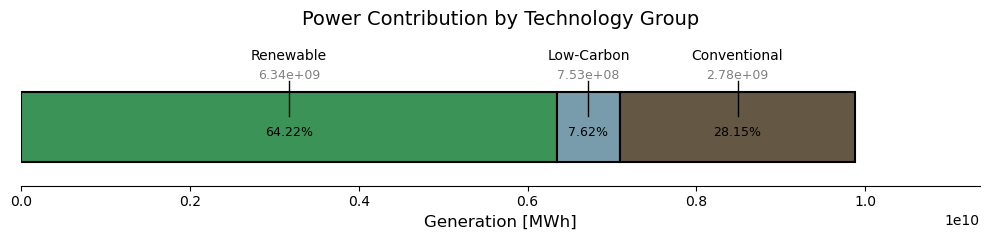

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_16217/3119974902.py:215: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



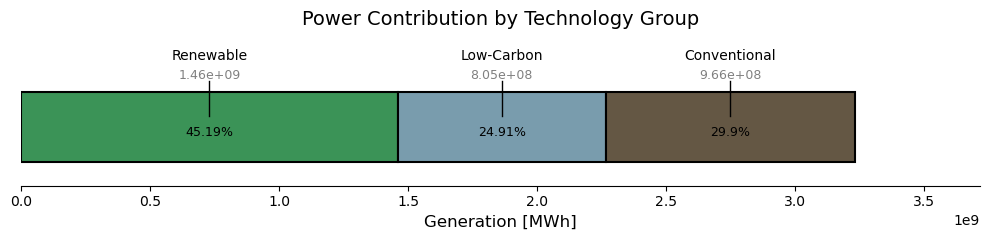

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_16217/3119974902.py:215: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



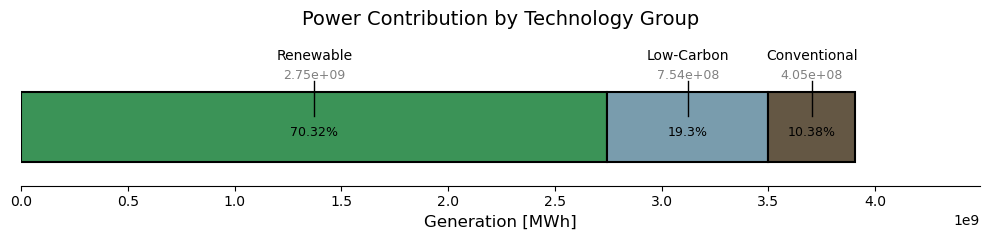

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_16217/3119974902.py:215: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



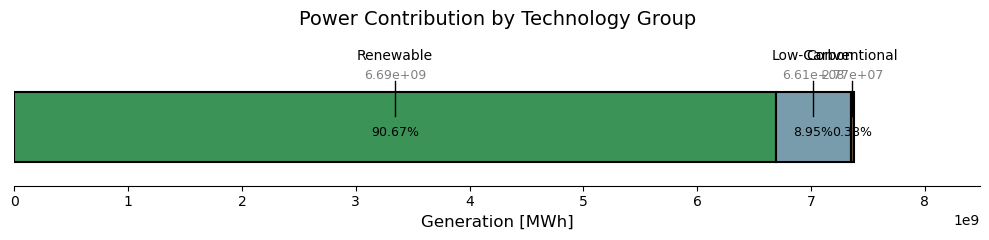

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_16217/3119974902.py:215: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



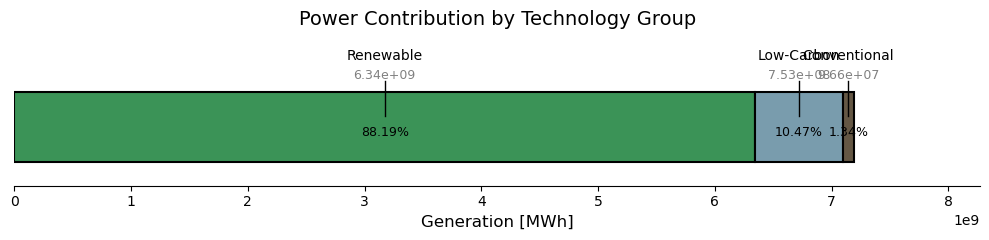

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [ ]:
BAU_no_flex_network_list = [BAU_no_flex_2020, BAU_no_flex_2030, BAU_no_flex_2040, BAU_no_flex_2050]
network_list_summary(BAU_no_flex_network_list)


In [22]:
#EV battery Size 
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['BAU no flex'] = [BAU_no_flex_network_list[1].stores[BAU_no_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[2].stores[BAU_no_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[3].stores[BAU_no_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size

#Additional Storage Cacpacity
def add_heat_store_capacity(network):
    return (network.stores[network.stores.index.str.contains('storage', case = False)].e_nom.sum())

#additional_heating_water_storage
additional_heating_water_storage = pd.DataFrame() #in MWH 
additional_heating_water_storage.index = [2020, 2030, 2040, 2050]
additional_heating_water_storage['BAU no flex'] = [add_heat_store_capacity(s) for s in BAU_no_flex_network_list]
additional_heating_water_storage

,BAU no flex
2020,0.0
2030,0.0
2040,0.0
2050,0.0


In [16]:
BAU_no_flex_2050.statistics().loc['Link'].loc['H2 turbine']

Optimal Capacity              0.155530
Installed Capacity            0.000000
Supply                        7.540590
Withdrawal                   17.536250
Energy Balance               -9.995660
Transmission                  0.000000
Capacity Factor               0.012859
Curtailment                   0.000000
Capital Expenditure        3026.367570
Operational Expenditure      83.682490
Revenue                    2243.034300
Market Value                297.732558
Name: H2 turbine, dtype: float64

In [ ]:

##Calculating renewable/conventional dispatch 

network = BAU_no_flex_2050
renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro']
## didn't include PHS in renewables, it ultimately takes more from than it supplies -- is useful at certain times 
## nuclear and geothermal not considered, as considered low carbon rather than renewable
conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
renewable_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in renewables]).sum()
renewable_sum

conventional_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in conventionals]).sum()
conventional_sum

print(f'Renewable sum is : {renewable_sum} \nConventional sum is : {conventional_sum}')

Renewable sum is : 6362553334.316126 
Conventional sum is : 96615943.54531825


In [ ]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - no flex : total (percentages for wind and solar)'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - no flex : solar
2020,16.742801,0.016843
2030,7.211807,0.907480
2040,1.743001,7.738854
2050,0.549747,1.778292


In [380]:
n = BAU_no_flex_2020
#this function is the same as it is in the make_summary.py file (makes the cost csv in the reuslts folder, gives more description)
#Ok this function might be double counting conventionals, because it is counting both the fuel supply for conventionals (coal, lignite, oil (not gas because it's listed differently)) and the marginal cost.  othe links that prepresent the power plants. 
#I think that it might be the case that the capcital cost of producing the raw material is passed onto the marginal cost of the technology that transforms raw material --> power, so I did this again just using statistics and not including orignal raw coal, lignite, and oil cost

def electric_only_costs(network):
    n = network.copy()
    opt_name = {"Store": "e", "Line": "s", "Transformer": "s"}
    capital_costs_grouped_dataframe = pd.Series()
    marginal_costs_grouped_dataframe = pd.Series() 
    for c in n.iterate_components(
            n.branch_components | n.controllable_one_port_components ^ {"Load"}
        ):
        capital_costs = c.df.capital_cost * c.df[opt_name.get(c.name, "p") + "_nom_opt"]
        capital_costs_grouped = capital_costs.groupby(c.df.carrier).sum()
        print(c.name)

        if c.name == "Link":
            p = c.pnl.p0.multiply(n.snapshot_weightings.generators, axis=0).sum()
        elif c.name == "Line":
            continue
        elif c.name == "StorageUnit":
            p_all = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0)
            p_all[p_all < 0.0] = 0.0
            p = p_all.sum()
        else:
            p = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0).sum()

        # correct sequestration cost
        if c.name == "Store":
            items = c.df.index[
                (c.df.carrier == "co2 stored") & (c.df.marginal_cost <= -100.0)
            ]
            c.df.loc[items, "marginal_cost"] = -20.0
        
        marginal_costs = p * c.df.marginal_cost
        #print(marginal_costs)
        marginal_costs_grouped = marginal_costs.groupby(c.df.carrier).sum()
        
        ##Eliminating the inclusion of the raw matieral supply for the conventional carriers, because I think that may be double counting and I want it to match gas...
        if c.name == 'Generator':
            conventionals = ['CCGT', 'OCGT', 'urban central CHP', 'urban central CHP CC', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
            marginal_costs_grouped = marginal_costs_grouped.drop(index = ['coal', 'lignite', 'oil'], errors = 'ignore')
            capital_costs_grouped = capital_costs_grouped.drop(index = ['coal', 'lignite', 'oil'], errors = 'ignore')
        else:
            renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro']
            conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
            #conventional raw material supply has a captial expenditure of 0, only production technologies like a coal link or a CCGT link have capital expenditure
            lines_and_link_costs = ['DC', 'battery charger', 'battery discharger', 'home battery charger', 'home battery discharger', 'rural air heat pump', 'rural biomass boiler', 'rural gas boiler',
       'rural ground heat pump', 'rural resistive heater',
       'rural water tanks charger', 'rural water tanks discharger', 'urban central air heat pump', 'urban central gas boiler',
       'urban central resistive heater', 'urban central solid biomass CHP',
       'urban central solid biomass CHP CC',
       'urban central water tanks charger',
       'urban central water tanks discharger', 'urban decentral air heat pump',
       'urban decentral biomass boiler', 'urban decentral gas boiler',
       'urban decentral oil boiler', 'urban decentral resistive heater',
       'urban decentral water tanks charger',
       'urban decentral water tanks discharger']

        if c.name == "Store":
            capital_costs_grouped_dataframe = capital_costs_grouped
        else:
            capital_costs_grouped_dataframe = pd.concat([capital_costs_grouped_dataframe, capital_costs_grouped])
            #print(capital_costs_grouped_dataframe)    

        if c.name == "Store":
            marginal_costs_grouped_dataframe = marginal_costs_grouped
            #print(marginal_costs_grouped_dataframe)
        else:
            marginal_costs_grouped_dataframe = pd.concat([marginal_costs_grouped_dataframe, marginal_costs_grouped])
            #print(marginal_costs_grouped_dataframe)
        
    power_sector_components = renewables + conventionals + lines_and_link_costs
    #filtering so it's just power sector components (so should not see 'gas')

    capital_costs_grouped_dataframe_power = capital_costs_grouped_dataframe.loc[capital_costs_grouped_dataframe.index.intersection(power_sector_components)]
    marginal_costs_grouped_dataframe_power = marginal_costs_grouped_dataframe.loc[capital_costs_grouped_dataframe.index.intersection(power_sector_components)]
    try: 
        del total_costs
    except:
        pass
    total_costs = marginal_costs_grouped_dataframe_power + capital_costs_grouped_dataframe_power
    total_costs_power = total_costs.loc[capital_costs_grouped_dataframe.index.intersection(power_sector_components)]
    return [capital_costs_grouped_dataframe_power, marginal_costs_grouped_dataframe_power, total_costs_power]

In [403]:
f'{(electric_only_costs(BAU_no_flex_2050)[2].sum()/ 1e9):.2e}' # This is the total cost in EUR, but only for one year I think... 




Store
Generator
StorageUnit
Line
Link


'3.74e+02'

In [ ]:
# Check that it's less than the total objective costs
print(electric_only_costs(BAU_no_flex_2020)[2].sum() < BAU_no_flex_2020.objective)
print(electric_only_costs(BAU_no_flex_2030)[2].sum() < BAU_no_flex_2030.objective)
print(electric_only_costs(BAU_no_flex_2040)[2].sum() < BAU_no_flex_2040.objective)
print(electric_only_costs(BAU_no_flex_2050)[2].sum() < BAU_no_flex_2050.objective)

Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
False


#### BAU Max Flex

In [405]:
BAU_max_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_max_flex/networks/base_s_39___2020.nc')
BAU_max_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_max_flex/networks/base_s_39___2030.nc')
BAU_max_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_max_flex/networks/base_s_39___2040.nc')
BAU_max_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/BAU_max_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [406]:
BAU_max_flex_network_list = [BAU_max_flex_2020, BAU_max_flex_2030, BAU_max_flex_2040, BAU_max_flex_2050]

#### Checks and Validation

In [407]:
#checks
for i, network in enumerate(BAU_max_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])
    


Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, const

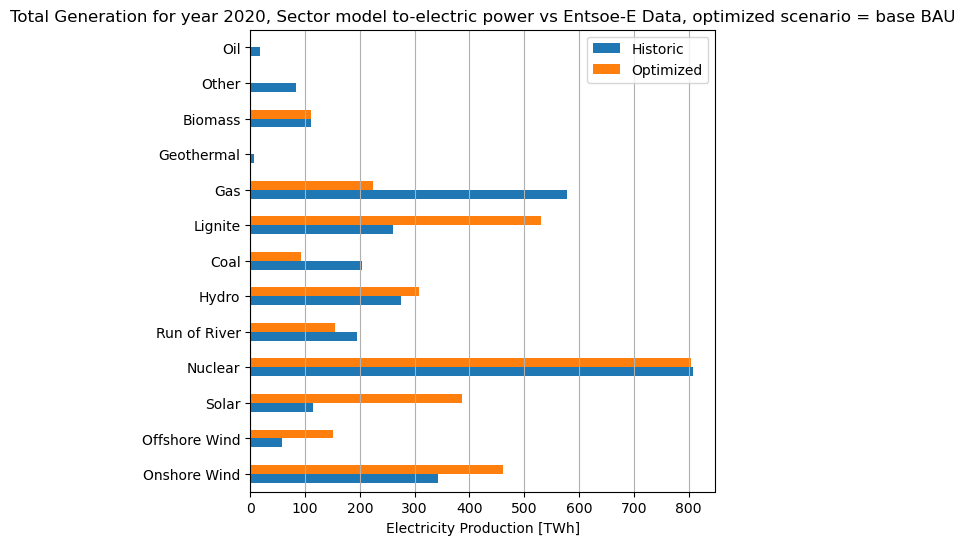

In [471]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(BAU_max_flex_2020)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

In [413]:
#EV battery Size 
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['BAU no flex'] = [BAU_no_flex_network_list[1].stores[BAU_no_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[2].stores[BAU_no_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[3].stores[BAU_no_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['BAU max flex'] = [BAU_max_flex_network_list[1].stores[BAU_max_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_max_flex_network_list[2].stores[BAU_max_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_max_flex_network_list[3].stores[BAU_max_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size



,BAU no flex,BAU max flex
2030,0.0,3.942057e+06
2040,0.0,9.198133e+06
2050,0.0,1.314019e+07


In [ ]:
#EV battery Size 
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['BAU no flex'] = [BAU_no_flex_network_list[1].stores[BAU_no_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[2].stores[BAU_no_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_no_flex_network_list[3].stores[BAU_no_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['BAU max flex'] = [BAU_max_flex_network_list[1].stores[BAU_max_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_max_flex_network_list[2].stores[BAU_max_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_max_flex_network_list[3].stores[BAU_max_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size


#Additional Storage Cacpacity
def add_heat_store_capacity(network):
    return (network.stores[network.stores.index.str.contains('storage', case = False)].e_nom.sum())

#additional_heating_water_storage
additional_heating_water_storage = pd.DataFrame() #in MWH 
additional_heating_water_storage.index = [2020, 2030, 2040, 2050]
additional_heating_water_storage['BAU no flex'] = [add_heat_store_capacity(s) for s in BAU_no_flex_network_list]
additional_heating_water_storage['BAU max flex'] = [add_heat_store_capacity(s) for s in BAU_max_flex_network_list]

additional_heating_water_storage

,BAU no flex,BAU max flex
2020,0.0,1800000.0
2030,0.0,1800000.0
2040,0.0,1800000.0
2050,0.0,1800000.0


#### Calculating Metrics

In [461]:
##Calculating renewable/conventional dispatch 

network = BAU_max_flex_2030
renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro', 'geothermal']
low_carbon = ['nuclear', 'H2 turbine', 'H2 Fuel Cell', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
## didn't include PHS in renewables, it ultimately takes more from than it supplies -- is useful at certain times 
## nuclear and geothermal not considered, as considered low carbon rather than renewable
conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC']
renewable_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in renewables]).sum()
renewable_sum
low_carbon_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in low_carbon]).sum()
low_carbon_sum
conventional_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in conventionals]).sum()
conventional_sum

print(f'Renewable sum is : {renewable_sum} \nLow Carbon sum is {low_carbon_sum} \nConventional sum is : {conventional_sum}')

Renewable sum is : 2922042801.850488 
Low Carbon sum is 855872487.5112711 
Conventional sum is : 142078770.20217314


In [447]:
electric_supply_from_the_sector_models(BAU_max_flex_2020)

{'offwind-ac': 150477824.84335747,
 'offwind-dc': 61.28983011616529,
 'offwind-float': 46.82000463104146,
 'onwind': 460895673.963876,
 'ror': 154379434.73824757,
 'solar': 330427189.1874542,
 'solar rooftop': 8121149.537867377,
 'solar-hsat': 47765817.40023089,
 'geothermal': 858477.9615636695,
 'nuclear': 804120590.6381425,
 'CCGT': 224000043.88895428,
 'H2 Fuel Cell': 39.96551915321338,
 'H2 turbine': 34.831480045832464,
 'OCGT': 74.66786107488953,
 'coal': 92795217.01314333,
 'lignite': 530521298.5235206,
 'oil': 18.05680851622934,
 'urban central CHP': 82.77752349624919,
 'urban central CHP CC': 58.0690548269311,
 'urban central solid biomass CHP': 110196010.46353266,
 'urban central solid biomass CHP CC': 33.605588979061594,
 'PHS': -4430691.787429511,
 'hydro': 311539621.47701365}

In [411]:
#costs
electric_only_costs(BAU_max_flex_2050)[2].sum()

Store
Generator
StorageUnit
Line
Link


364478586505.30457

In [462]:
# Check that it's less than the total objective costs
print(electric_only_costs(BAU_max_flex_2020)[2].sum() < BAU_max_flex_2020.objective)
print(electric_only_costs(BAU_max_flex_2030)[2].sum() < BAU_max_flex_2030.objective)
print(electric_only_costs(BAU_max_flex_2040)[2].sum() < BAU_max_flex_2040.objective)
print(electric_only_costs(BAU_max_flex_2050)[2].sum() < BAU_max_flex_2050.objective)

Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
False


#### Investigate: WHY is this last one false : the electric costs are greater than the osts of the entire system? Is there a negative sector component somewhere that is bringing down the entire system costs? 

In [468]:
electric_only_costs(BAU_max_flex_2050)[2].sum()

Store
Generator
StorageUnit
Line
Link


364478586505.30457

In [469]:
BAU_max_flex_2050.objective

120006765632.45126

Curatilment Fraction

In [ ]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_max_flex_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_max_flex_network_list ]



curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar,BAU - no flex : total (percentages for wind and solar)
2020,16.742801,17.287996,0.016843,0.011824,0.016843
2030,7.211807,6.745177,0.907480,0.126353,0.907480
2040,1.743001,6.155229,7.738854,4.045214,7.738854
2050,0.549747,7.828315,1.778292,0.244707,1.778292


In [474]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_max_flex_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_max_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar
2020,2453434.933246,2403292.889663,55266.784946,38601.740758
2030,3771201.053732,2287633.563732,3194058.147169,418331.635547
2040,29731986.101996,18431453.569543,23797822.157786,12183167.126809
2050,9624480.093133,5452285.825166,5237383.670905,971481.833709


# Transmission Restriction -- c3.0

In [500]:
transmission_restriction_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission Restriction c3.0 - no flex/networks/base_s_39___2020.nc')
transmission_restriction_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission Restriction c3.0 - no flex/networks/base_s_39___2030.nc')
transmission_restriction_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission Restriction c3.0 - no flex/networks/base_s_39___2040.nc')
transmission_restriction_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission Restriction c3.0 - no flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [482]:
transmission_restriction_max_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission_restriction_c3.0_max_flex/networks/base_s_39___2020.nc')
transmission_restriction_max_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission_restriction_c3.0_max_flex/networks/base_s_39___2030.nc')
transmission_restriction_max_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission_restriction_c3.0_max_flex/networks/base_s_39___2040.nc')
transmission_restriction_max_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Transmission_restriction_c3.0_max_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [477]:
Transmission_restriction_no_flex_network_list = [transmission_restriction_no_flex_2020, transmission_restriction_no_flex_2030, transmission_restriction_no_flex_2040, transmission_restriction_no_flex_2050 ]

In [483]:
Transmission_restriction_max_flex_network_list = [transmission_restriction_max_flex_2020, transmission_restriction_max_flex_2030, transmission_restriction_max_flex_2040, transmission_restriction_max_flex_2050 ]

### Validation and Checks

In [484]:
#checks
for i, network in enumerate(Transmission_restriction_no_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])
    


Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the con

In [485]:
#checks
for i, network in enumerate(Transmission_restriction_max_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])
    

Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
Yes, transmission limit exists
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the con

In [486]:
#EV battery Size 
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['TX no flex'] = [Transmission_restriction_no_flex_network_list[1].stores[Transmission_restriction_no_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), Transmission_restriction_no_flex_network_list[2].stores[Transmission_restriction_no_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), Transmission_restriction_no_flex_network_list[3].stores[Transmission_restriction_no_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['TX max flex'] = [Transmission_restriction_max_flex_network_list[1].stores[Transmission_restriction_max_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), Transmission_restriction_max_flex_network_list[2].stores[Transmission_restriction_max_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), Transmission_restriction_max_flex_network_list[3].stores[Transmission_restriction_max_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]

EV_store_size


,TX no flex,TX max flex
2030,0.0,3.942057e+06
2040,0.0,9.198133e+06
2050,0.0,1.314019e+07


In [487]:

#Additional Storage Cacpacity
def add_heat_store_capacity(network):
    return (network.stores[network.stores.index.str.contains('storage', case = False)].e_nom.sum())

#additional_heating_water_storage
additional_heating_water_storage = pd.DataFrame() #in MWH 
additional_heating_water_storage.index = [2020, 2030, 2040, 2050]
additional_heating_water_storage['TX no flex'] = [add_heat_store_capacity(s) for s in Transmission_restriction_no_flex_network_list]
additional_heating_water_storage['TX max flex'] = [add_heat_store_capacity(s) for s in Transmission_restriction_max_flex_network_list]

additional_heating_water_storage

,TX no flex,TX max flex
2020,0.0,1800000.0
2030,0.0,1800000.0
2040,0.0,1800000.0
2050,0.0,1800000.0


### Network Metrics

In [512]:
#costs
electric_only_costs(transmission_restriction_max_flex_2050)[2].sum()

Store
Generator
StorageUnit
Line
Link


364971924267.6619

In [501]:
##Calculating renewable/conventional dispatch 

network = transmission_restriction_no_flex_2050
renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro', 'geothermal']
low_carbon = ['nuclear', 'H2 turbine', 'H2 Fuel Cell', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
## didn't include PHS in renewables, it ultimately takes more from than it supplies -- is useful at certain times 
## nuclear and geothermal not considered, as considered low carbon rather than renewable
conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC']
renewable_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in renewables]).sum()
renewable_sum
low_carbon_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in low_carbon]).sum()
low_carbon_sum
conventional_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in conventionals]).sum()
conventional_sum

print(f'Renewable sum is : {renewable_sum} \nLow Carbon sum is {low_carbon_sum} \nConventional sum is : {conventional_sum}')

Renewable sum is : 6363727471.036514 
Low Carbon sum is 760127895.3551923 
Conventional sum is : 88246645.98120551


In [ ]:
# Check that it's less than the total objective costs
print(electric_only_costs(transmission_restriction_no_flex_2050)[2].sum() < transmission_restriction_max_flex_2020.objective)
print(electric_only_costs(transmission_restriction_no_flex_2020)[2].sum() < transmission_restriction_max_flex_2030.objective)
print(electric_only_costs(transmission_restriction_no_flex_2030)[2].sum() < transmission_restriction_max_flex_2040.objective)
print(electric_only_costs(transmission_restriction_no_flex_2040)[2].sum() < transmission_restriction_max_flex_2050.objective)

Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
True
Store
Generator
StorageUnit
Line
Link
False


# The last cost inequality is also False : WHAT IS DRIVING THE PRICE UP OR DOWN TO MAKE THAT HAPPEN?


Curtailment 

In [503]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['TX - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in Transmission_restriction_no_flex_network_list ]
curtailment_dataframe['TX - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in Transmission_restriction_max_flex_network_list ]

curtailment_dataframe['TX - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in Transmission_restriction_no_flex_network_list ]
curtailment_dataframe['TX - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in Transmission_restriction_max_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,TX - no flex : wind,TX - max flex : wind,TX - no flex : solar,TX - max flex : solar
2020,16.945104,17.054213,0.016612,0.011265
2030,6.291993,6.385465,0.791847,0.126961
2040,2.175313,5.867549,8.092411,3.463743
2050,2.175313,7.990391,8.092411,0.154047


In [504]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_max_flex_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_max_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar
2020,2453434.933246,2403292.889663,55266.784946,38601.740758
2030,3771201.053732,2287633.563732,3194058.147169,418331.635547
2040,29731986.101996,18431453.569543,23797822.157786,12183167.126809
2050,9624480.093133,5452285.825166,5237383.670905,971481.833709


# Hydrogen Minimums

In [429]:
hydrogen_minums_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_mins_no_flex/networks/base_s_39___2020.nc')
hydrogen_minums_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_mins_no_flex/networks/base_s_39___2030.nc')
hydrogen_minums_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_mins_no_flex/networks/base_s_39___2040.nc')
hydrogen_minums_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_mins_no_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [435]:
hydrogen_minimums_max_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_minimums_max_flex/networks/base_s_39___2020.nc')
hydrogen_minimums_max_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_minimums_max_flex/networks/base_s_39___2030.nc')
hydrogen_minimums_max_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_minimums_max_flex/networks/base_s_39___2040.nc')
hydrogen_minimums_max_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Hydrogen_minimums_max_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [513]:
hydrogen_minimums_no_flex_network_list = [hydrogen_minums_no_flex_2020, hydrogen_minums_no_flex_2030, hydrogen_minums_no_flex_2040, hydrogen_minums_no_flex_2050 ]
hdyrogen_minimums_max_flex_network_list = [hydrogen_minimums_max_flex_2020, hydrogen_minimums_max_flex_2030, hydrogen_minimums_max_flex_2040, hydrogen_minimums_max_flex_2050 ]

In [514]:
#checks
for i, network in enumerate(hydrogen_minimums_no_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])
    

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, const

In [516]:
#checks
for i, network in enumerate(hdyrogen_minimums_max_flex_network_list):
    years = [2020, 2030, 2040, 2050]
    carbon_constraint_check(network)
    transmission_limit_test(network, years[i])
    hydrogen_electrolysis_limit_test(network, years[i])
    carbon_sequestration_limit_test(network, years[i])

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Carbon constraint exists
Yes, Carbon constraint abided by 
No transmission limit
Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, const

In [517]:
#EV battery Size 
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['EV no flex'] = [hydrogen_minimums_no_flex_network_list[1].stores[hydrogen_minimums_no_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), hydrogen_minimums_no_flex_network_list[2].stores[hydrogen_minimums_no_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), hydrogen_minimums_no_flex_network_list[3].stores[hydrogen_minimums_no_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['EV max flex'] = [hdyrogen_minimums_max_flex_network_list[1].stores[hdyrogen_minimums_max_flex_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), hdyrogen_minimums_max_flex_network_list[2].stores[hdyrogen_minimums_max_flex_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), hdyrogen_minimums_max_flex_network_list[3].stores[hdyrogen_minimums_max_flex_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size


,EV no flex,EV max flex
2030,0.0,3.942057e+06
2040,0.0,9.198133e+06
2050,0.0,1.314019e+07


In [518]:
#Additional Storage Cacpacity
def add_heat_store_capacity(network):
    return (network.stores[network.stores.index.str.contains('storage', case = False)].e_nom.sum())

#additional_heating_water_storage
additional_heating_water_storage = pd.DataFrame() #in MWH 
additional_heating_water_storage.index = [2020, 2030, 2040, 2050]
additional_heating_water_storage['BAU no flex'] = [add_heat_store_capacity(s) for s in hydrogen_minimums_no_flex_network_list]
additional_heating_water_storage['BAU max flex'] = [add_heat_store_capacity(s) for s in hdyrogen_minimums_max_flex_network_list]

additional_heating_water_storage

,BAU no flex,BAU max flex
2020,0.0,1800000.0
2030,0.0,1800000.0
2040,0.0,1800000.0
2050,0.0,1800000.0


In [528]:
electric_only_costs(hydrogen_minimums_max_flex_2020)[2].sum()

Store
Generator
StorageUnit
Line
Link


258067530283.2598

In [ ]:
electric_supply_from_the_sector_models()

In [538]:
##Calculating renewable/conventional dispatch 

network = hydrogen_minimums_max_flex_2050
renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro', 'geothermal']
low_carbon = ['nuclear', 'H2 turbine', 'H2 Fuel Cell', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
## didn't include PHS in renewables, it ultimately takes more from than it supplies -- is useful at certain times 
## nuclear and geothermal not considered, as considered low carbon rather than renewable
conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC']
renewable_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in renewables]).sum()
renewable_sum
low_carbon_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in low_carbon]).sum()
low_carbon_sum
conventional_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in conventionals]).sum()
conventional_sum

print(f'Renewable sum is : {renewable_sum} \nLow Carbon sum is {low_carbon_sum} \nConventional sum is : {conventional_sum}')

Renewable sum is : 6423182589.899633 
Low Carbon sum is 782668002.7545943 
Conventional sum is : 111858603.7698727


In [539]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in hydrogen_minimums_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in hdyrogen_minimums_max_flex_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in hydrogen_minimums_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in hdyrogen_minimums_max_flex_network_list ]



curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar
2020,16.468377,17.402388,0.016874,0.011675
2030,6.527384,6.873002,0.813143,0.151465
2040,1.978218,1.294641,8.420248,4.643589
2050,0.578581,0.223703,3.140670,1.082338


In [540]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in hydrogen_minimums_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in hdyrogen_minimums_max_flex_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in hydrogen_minimums_no_flex_network_list ]
curtailment_dataframe['BAU - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in hdyrogen_minimums_max_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar
2020,2453373.309898,2401895.385384,55221.271073,38244.192250
2030,3887258.884728,2298199.517685,3182661.437388,501730.697261
2040,26159828.355177,16585201.877657,24967479.915418,13314677.128234
2050,6875903.918685,3538075.419877,7544242.348996,2319159.930024


## CCUS Scenario

In [541]:
CCUS_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Carbon_minimums_no_flex/networks/base_s_39___2020.nc')
CCUS_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Carbon_minimums_no_flex/networks/base_s_39___2030.nc')
CCUS_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Carbon_minimums_no_flex/networks/base_s_39___2040.nc')
CCUS_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/Carbon_minimums_no_flex/networks/base_s_39___2050.nc')
                                                                    

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [542]:
CCUS_max_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/CCUS_min_max_flex/networks/base_s_39___2020.nc')
CCUS_max_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/CCUS_min_max_flex/networks/base_s_39___2030.nc')
CCUS_max_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/CCUS_min_max_flex/networks/base_s_39___2040.nc')
CCUS_max_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Third Run Results/CCUS_min_max_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [563]:
CCUS_no_flex_network_list = [CCUS_no_flex_2020, CCUS_no_flex_2030, CCUS_no_flex_2040, CCUS_no_flex_2050 ]
CCUS_max_flex_network_list = [CCUS_max_flex_2020, CCUS_max_flex_2030, CCUS_max_flex_2040, CCUS_max_flex_2050 ]

In [554]:
electric_only_costs(CCUS_max_flex_2050)[2].sum()

Store
Generator
StorageUnit
Line
Link


500060461699.18524

In [562]:
##Calculating renewable/conventional dispatch 

network = CCUS_max_flex_2050
renewables =  ['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind', 'ror', 'solar', 'solar rooftop', 'solar-hsat', 'hydro', 'geothermal']
low_carbon = ['nuclear', 'H2 turbine', 'H2 Fuel Cell', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC']
## didn't include PHS in renewables, it ultimately takes more from than it supplies -- is useful at certain times 
## nuclear and geothermal not considered, as considered low carbon rather than renewable
conventionals = ['CCGT', 'OCGT', 'coal', 'lignite', 'oil', 'urban central CHP', 'urban central CHP CC']
renewable_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in renewables]).sum()
renewable_sum
low_carbon_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in low_carbon]).sum()
low_carbon_sum
conventional_sum = pd.Series([electric_supply_from_the_sector_models(network)[key] for key in conventionals]).sum()
conventional_sum

print(f'Renewable sum is : {renewable_sum} \nLow Carbon sum is {low_carbon_sum} \nConventional sum is : {conventional_sum}')

Renewable sum is : 8728168168.765526 
Low Carbon sum is 280595355.8877692 
Conventional sum is : 42720459.25499825


In [ ]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['CCUS - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_no_flex_network_list ]
curtailment_dataframe['CCUS- max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_max_flex_network_list ]

curtailment_dataframe['CCUS- no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_no_flex_network_list ]
curtailment_dataframe['CCUS - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_max_flex_network_list ]



curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,BAU - no flex : wind,BAU - max flex : wind,BAU - no flex : solar,BAU - max flex : solar
2020,17.510038,17.105891,0.017103,0.011675
2030,5.578610,5.354806,0.815077,0.126771
2040,5.259733,4.984297,22.239419,16.486746
2050,1.952865,1.451706,16.651947,7.451907


In [565]:
### Calculating Curtailment Fraction 

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['CCUS - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_no_flex_network_list ]
curtailment_dataframe['CCUS - max flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_max_flex_network_list ]

curtailment_dataframe['CCUS - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_no_flex_network_list ]
curtailment_dataframe['CCUS - max flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_max_flex_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

,CCUS - no flex : wind,CCUS - max flex : wind,CCUS - no flex : solar,CCUS - max flex : solar
2020,2452539.808068,2403900.949759,56041.100320,38235.039403
2030,4736250.322263,2296263.964354,3533745.129835,419715.753526
2040,87210251.329777,79729253.186518,91207443.899013,61141028.800360
2050,27901621.627160,22251117.899656,50910261.980748,21391261.374375


## To Change the cost to have high hydrogen

In [ ]:
#loading costs files 
costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2020.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value

#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 




In [ ]:
def electric_system_cost(network):
    electric_components:
    return cost 